In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
microsoft_df=pd.read_csv('Microsoft_Data.csv')

microsoft_df
y=microsoft_df['HasDetections']
microsoft_df.drop(columns='HasDetections',inplace=True)
microsoft_df.shape


(56756, 82)

In [3]:
import scipy.stats

crosstab=pd.crosstab(microsoft_df['OsBuild'],microsoft_df['Census_InternalBatteryNumberOfCharges'])

result=scipy.stats.chi2_contingency(crosstab)
#crosstab
result
microsoft_df.shape

(56756, 82)

In [4]:
missing_value_df=pd.DataFrame({'Column_Name':microsoft_df.columns,
                             'missing_value_count':microsoft_df.isnull().sum(),
                             'missing_value_percent':microsoft_df.isnull().sum()/microsoft_df.shape[0]*100})

missing_value_df.sort_values(by='missing_value_percent',ascending=False)

cols_drop=list(missing_value_df[missing_value_df['missing_value_percent']>50]['Column_Name'])
cols_drop

microsoft_df['SmartScreen'].value_counts()
microsoft_df.shape
cols_drop

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

In [5]:
for col in microsoft_df.columns:
    if microsoft_df[col].nunique()==microsoft_df.shape[0] or microsoft_df[col].nunique()==1:
        cols_drop.append(col)
cols_drop

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled',
 'MachineIdentifier',
 'IsBeta',
 'AutoSampleOptIn',
 'PuaMode',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsWIMBootEnabled']

In [6]:

#microsoft_df.columns

microsoft_df.drop(columns=cols_drop,inplace=True)
microsoft_df.shape

(56756, 71)

In [7]:
for col in microsoft_df.columns:
    if col!='Census_SystemVolumeTotalCapacity':
        microsoft_df[col]=microsoft_df[col].astype(object)
microsoft_df['Census_SystemVolumeTotalCapacity'].dtype



dtype('float64')

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(microsoft_df,y,test_size=0.2,random_state=43)

X_train.shape

(45404, 71)

In [9]:
for col in X_train.columns:
    if X_train[col].dtype=='object':
        X_train[col]=X_train[col].fillna(X_train[col].mode()[0]).astype(object)
        X_test[col]=X_test[col].fillna(X_train[col].mode()[0]).astype(object)
    
    else:
        X_train[col]=X_train[col].fillna(X_train[col].mean())
        X_test[col]=X_test[col].fillna(X_train[col].mean())
        
X_train.dtypes

ProductName                                object
EngineVersion                              object
AppVersion                                 object
AvSigVersion                               object
RtpStateBitfield                           object
                                            ...  
Census_IsTouchEnabled                      object
Census_IsPenCapable                        object
Census_IsAlwaysOnAlwaysConnectedCapable    object
Wdft_IsGamer                               object
Wdft_RegionIdentifier                      object
Length: 71, dtype: object

In [10]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)
    
le=LabelEncoderExt()

for col in X_train.columns:
    if X_train[col].dtype=='object':
        le.fit(X_train[col])
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])


In [11]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

logreg.fit(X_train,Y_train)

Y_pred=logreg.predict(X_test)


In [26]:
comparison_df=pd.DataFrame({'Actuals':Y_test,'Predictions':Y_pred})

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

print(recall_score(Y_test,Y_pred))

print(precision_score(Y_test,Y_pred))

print(confusion_matrix(Y_test,Y_pred))

print(f1_score(Y_test,Y_pred))

0.5725764192139738
0.5649775939331265
[[3103 2524]
 [2447 3278]]
0.5687516266157716


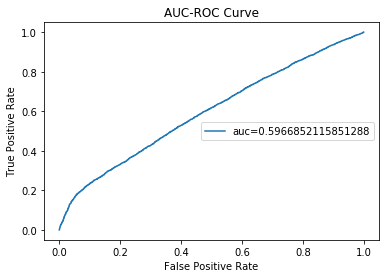

In [13]:
Y_pred_proba = logreg.predict_proba(X_test)[::,1]

fpr,tpr,thresholds=roc_curve(Y_test,Y_pred_proba) # the function roc_curve returns three values, the False Positive Rate,True Positive rate
                                                # threshold values it used to calculate the TPR and FPR

auc = roc_auc_score(Y_test, Y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')

plt.legend(loc=5)
plt.show()

In [24]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,Y_train)

Y_predict=clf.predict(X_test)

print(confusion_matrix(Y_predict,Y_test))
[]
print(recall_score(Y_predict,Y_test))

print(precision_score(Y_predict,Y_test))

print(f1_score(Y_predict,Y_test))

[[3215 3312]
 [2412 2413]]
0.5001036269430051
0.42148471615720523
0.4574407582938389


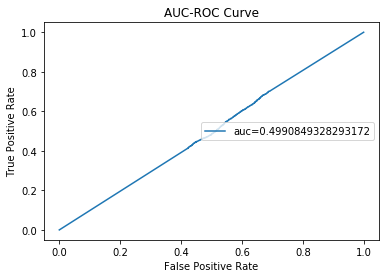

In [25]:
Y_predict_proba = clf.predict_proba(X_test)[::,1]

fpr,tpr,thresholds=roc_curve(Y_test,Y_predict_proba) # the function roc_curve returns three values, the False Positive Rate,True Positive rate
                                                # threshold values it used to calculate the TPR and FPR

auc = roc_auc_score(Y_test, Y_predict_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')

plt.legend(loc=5)
plt.show()